# 로지스틱 회귀 
- 종속 변수가 범주형인 경우 적용하는 회귀 분석 방식
- 종속 변수 Y를 직접 모델링 하지 않고 Y가 특정 범주에 속하는 확률을 모델링 

- 매개변수 
    - penalty
        - 기본값 : 'l2'
        - 규제 방식을 선택
            - l1 : Lasso
            - l2 : Rigde
            - elasticnet : l1 + l2 혼합
            - none : 규제 없음
    - dual
        - 기본값 : False
        - solver 매개변수의 값이 'liblinear'인 경우 사용
        - 쌍대 문제를 생성하여 해답을 내는 과정을 사용할것인가?
        - 데이터의 갯수가 적은 경우 
    - C
        - 기본값 : 1.0
        - 규제 강도의 역수 
            - 작을수록 -> 규제 강도 up (과적합 방지)
            - 클수록 -> 규제 강도 down (유연)
    - class_weight
        - 기본값 : None
        - 클래스의 불균형을 처리 
            - 'balanced' : 클래스의 빈도에 반비례하게 가중치를 부여 
            - dict형 데이터 -> {클래스명 : 가중치, ..} -> 특정 클래스에 가중치를 선택하여 지정
    - solver 
        - 기본값 : lbfgs
        - 최적의 알고리즘은 선택 ( 데이터의 크기 /  규제 )
            - liblinear : 적은 데이터, L1 / L2 지원
            - lbfgs : 다중 클래스를 지원 빠르고 안정적, L2 / None 지원
            - saga : 대규모 데이터, L1 / L2 / ElasticNet 지원
            - newton-cg, sag : 대규모 데이터, L2 / None 지원
    - multi_class
        - 기본값 : auto
        - 다중 클래스의 처리 방식 지정 
            - ovr(One - vs - Rest) : 2진분류를 반복 작업 
            - multinomial : (Softmax기반, solver 제한)
            - auto : solver와 데이터의 크기를 기반으로 자동 설정 
    - l1_ratio
        - 기본값 : None
        - 규제 방식이 ElasticNet인 경우 L1 패널티의 비중

- 속성 ( fit()함수를 이용하여 학습을 한 뒤 생성이되는 데이터 )
    - coef_    
        - 회귀 계수 출력
    - intercept_ 
        - 절편의 값
    - classes_
        - 학습 된 클래스
- 매서드 (class 안에 함수들)
    - fit(x, y)
        - 모델의 학습
    - predict(x)
        - 클래스를 예측
    - predict_proba(x)
        - 클래스 별 확률
    - predict_log_proba(x)
        - 클래스 별 로그 확률
    - decision_function(x)
        - 클래스 별 점수 
    - score(x, y)
        - 정확도 
    - get_params()
        - 모델 생성시 하이퍼파라미터의 인자값

In [34]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
# 분류 모델의 평가지표
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
    f1_score, confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import warnings

In [35]:
# 경고 메시지 출력을 필터 
warnings.filterwarnings('ignore')

In [36]:
body = pd.read_csv("../data/bodyPerformance.csv")
body.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [37]:
body.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [38]:
# gender 컬럼의 데이터의 유일한 값 출력 
body['gender'].unique()

array(['M', 'F'], dtype=object)

In [39]:
# 빈도수를 확인 
body['gender'].value_counts()

gender
M    8467
F    4926
Name: count, dtype: int64

In [40]:
# gender 컬럼의 데이터를 M은 0으로 F는 1로 변환 
body['gender'].map(
    lambda x : 0 if x == 'M' else 1
).value_counts()

gender
0    8467
1    4926
Name: count, dtype: int64

In [41]:
body['gender'].map(
    {
        'M' : 0, 
        'F' : 1
    }
).value_counts()

gender
0    8467
1    4926
Name: count, dtype: int64

In [42]:
body['gender'].replace('M', 0).replace('F', 1).value_counts()

gender
0    8467
1    4926
Name: count, dtype: int64

In [43]:
body['gender'] = np.where(
    body['gender'] == 'M', 0, 1
)

In [44]:
# class 컬럼의 데이터를 이진 분류 
# A는 1 나머지는 0으로 
body['class_1'] = np.where(
    body['class'] == 'A', 1, 0
)

In [45]:
body['class_1'].value_counts()

class_1
0    10045
1     3348
Name: count, dtype: int64

In [46]:
# 독립 변수, 종속 변수 나눠주기
x = body.drop(['class', 'class_1'], axis=1).values
y = body['class_1'].values

In [47]:
# train, test 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

In [48]:
print(X_train.shape, X_test.shape)

(9375, 11) (4018, 11)


In [49]:
# 로지스틱 회귀 모델을 생성 
logR = LogisticRegression(class_weight='balanced')

In [50]:
# 모델의 학습
logR.fit(X_train, Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [51]:
# 확률 추정 그래프 시각화
proba = pd.DataFrame(logR.predict_proba(X_train))

In [52]:
# 클래스의 점수( 분류의 대한 확신의 점수  )
cs = pd.DataFrame(logR.decision_function(X_train))

In [53]:
df = pd.concat( [proba, cs], axis=1 )
# 컬럼의 이름을 변경 
df.columns = [ 'Not A', 'A', 'decision_function' ]

df.sort_values('decision_function', inplace=True)
df.reset_index(drop=True, inplace=True)

df

,Not A,A,decision_function
0,1.000000,1.710924e-08,-17.883647
1,1.000000,2.465714e-08,-17.518199
2,1.000000,9.909207e-08,-16.127216
3,1.000000,1.918134e-07,-15.466743
4,1.000000,2.003580e-07,-15.423160
...,...,...,...
9370,0.000412,9.995882e-01,7.794488
9371,0.000378,9.996222e-01,7.880718
9372,0.000351,9.996487e-01,7.953634
9373,0.000120,9.998797e-01,9.025665


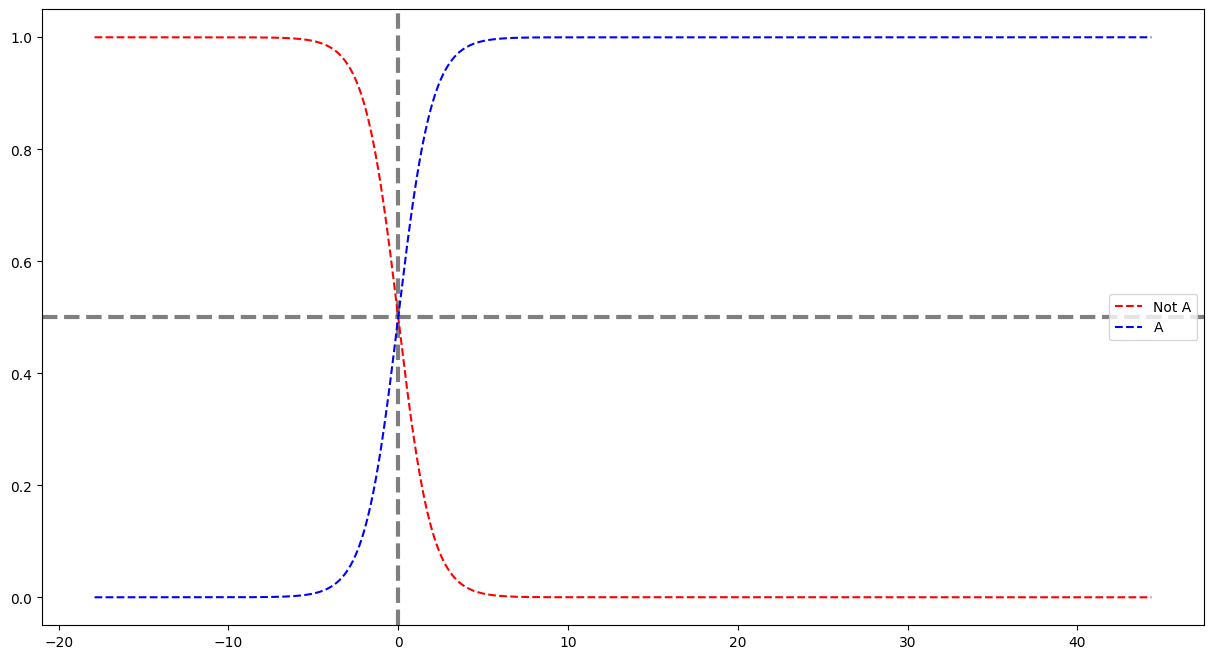

In [54]:
# 그래프 시각화 
plt.figure(figsize=(15, 8))

# 보조선 
plt.axhline(y = 0.5, linestyle = '--', color = 'black', linewidth=3, alpha=0.5)
plt.axvline(x = 0, linestyle = '--', color = 'black', linewidth=3, alpha=0.5)

plt.plot(df['decision_function'], df['Not A'], 'r--', label='Not A')
plt.plot(df['decision_function'], df['A'], 'b--', label='A')

plt.legend()

plt.show()

- 분류 분석의 평가 지표

- 정확도 
    - 실제 데이터와 예측 데이터가 얼마나 같은지 판단하는 지표 
    - TN + TP / TN + TP + FP + FN
- 혼동행렬
    - 이진 분류의 예측 오류가 얼마인가 어떠한 유형의 오류가 발생하는지를 나타내는 지표
        - TN : 예측 값이 Negative(0), 실제 값이 Negative(0)
        - FP : 예측 값이 Positive(1), 실제 값이 Negative(0)
        - FN : 예측 값이 Negative(0), 실제 값이 Positive(1)
        - TP : 예측 값이 Positive(1), 실제 값이 Positive(1)
- 정밀도 
    - Positive로 예측한 것들 중 실제 값이 Positive인 것들의 비율
    - 양성 예측도라 부른다. 
    - 해당 데이터가 중요성을 가지는 경우는 실제 Negative인 데이터를 Positive로 잘못 예측했을 때 업무상 큰 문제가 발생하는 경우 
    - TP / TP + FP
- 재현율 
    - 실제 Positive인 것들 중 예측이 Positive인 것들의 비율
    - TP / TP + FN

- F1_score
    - 정밀도와 재현율을 결합한 분류 성능 지표 
    - 정밀도와 재현율이 어느 한쪽으로 치우치지 않고 적절하게 조화를 이루었을때 높은 수치를 나타냄
    - 2 * 정밀도 * 재현율 / 정밀도 + 재현율
    - 2 * TP / 2 * TP + FP + FN

In [55]:
# 분석 모델의 예측

pred = logR.predict(X_test)

In [56]:
# 혼동행렬 
cm = confusion_matrix(Y_test, pred)
# 정확도
acc = accuracy_score(Y_test, pred)
# 정밀도 
prc = precision_score(Y_test, pred)
# 재현율
rcll = recall_score(Y_test, pred)
# f1score
f1 = f1_score(Y_test, pred)

In [57]:
print("혼동행렬 : ", cm)
print("정확도 : ", round(acc, 2))
print('정밀도 : ', round(prc, 2))
print('재현율 : ', round(rcll, 2))
print('F1스코어 : ', round(f1, 2))

혼동행렬 :  [[2457  521]
 [ 163  877]]
정확도 :  0.83
정밀도 :  0.63
재현율 :  0.84
F1스코어 :  0.72


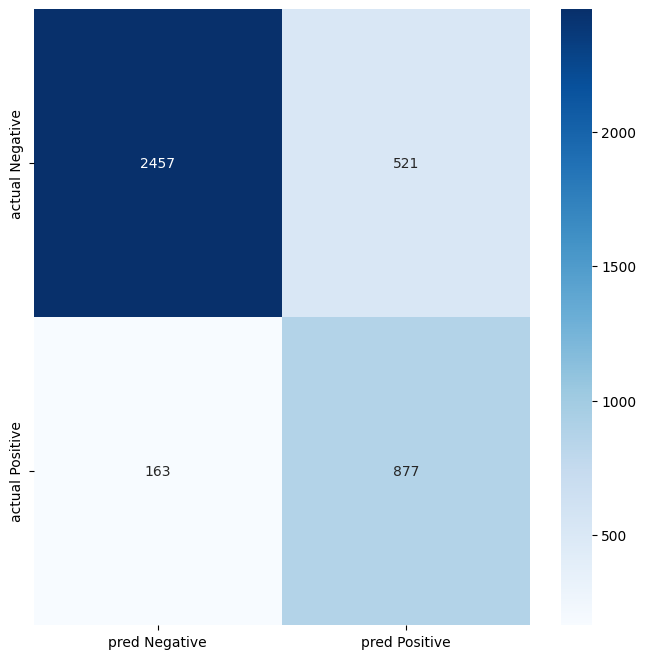

In [58]:
# 혼동행렬을 히트맵으로 시각화 
plt.figure(figsize=(8, 8))

sns.heatmap(
    cm, annot = True, cmap = 'Blues', fmt='d',
    xticklabels= ['pred Negative', 'pred Positive'], 
    yticklabels= ['actual Negative', 'actual Positive']
)

plt.show()

In [59]:
body

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class,class_1
0,27.0,0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C,0
1,25.0,0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A,1
2,31.0,0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C,0
3,32.0,0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B,0
4,28.0,0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13388,25.0,0,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0,C,0
13389,21.0,0,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0,D,0
13390,39.0,0,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0,A,1
13391,64.0,1,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0,D,0


In [60]:
# body 데이터프레임의 class 컬럼의 데이터를 A->0, B->1, C->2, D->3으로 변경하여 class_2새로운 컬럼에 대입
# np.where(조건식, 참인경우 데이터, 거짓인 경우 데이터)
np.where(body['class'] == 'A', 0,
        np.where(body['class'] == 'B', 1,
            np.where(body['class'] == 'C', 2, 3)))

array([2, 0, 2, ..., 0, 3, 2], shape=(13393,))

In [61]:
# map() 함수
body['class'].map(
    {
        'A' : 0,
        'B' : 1,
        'C' : 2,
        'D' : 3
    } 
)

0        2
1        0
2        2
3        1
4        1
        ..
13388    2
13389    3
13390    0
13391    3
13392    2
Name: class, Length: 13393, dtype: int64

In [65]:
body['class_2'] = body['class'].map(
    lambda x : 0 if x == 'A' else 1 if x == 'B' else 2 if x == 'C' else 3
)

In [66]:
body['class_2'].value_counts()

class_2
2    3349
3    3349
0    3348
1    3347
Name: count, dtype: int64

In [68]:
# 독립 변수, 종속 변수 데이터 생성
x = body.drop(['class', 'class_1', 'class_2'], axis=1).values
y = body['class_2'].values

In [69]:
# 데이터셋을 train, test 데이터로 분할 (y의 데이터의 비율을 그대로 분할)
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y,
    test_size= 0.3,
    random_state=42,
    stratify=y
)


In [72]:
pd.Series(Y_train).value_counts()

2    2344
3    2344
0    2344
1    2343
Name: count, dtype: int64

In [71]:
pd.Series(Y_test).value_counts()

2    1005
3    1005
1    1004
0    1004
Name: count, dtype: int64

In [73]:
# 로지스틱회귀 모델을 선정
# multi_class : 다중 클래스 -> ovr(이진 분류를 반복적), multinomial(다중 클래스 계산)
softm = LogisticRegression(multi_class='multinomial', C = 10)

In [74]:
# 데이터 학습
softm.fit(X_train, Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'multinomial'


In [75]:
# 예측
pred = softm.predict(X_test)

In [76]:
# 성능 평가 -> sklearn안에 metrics -> 함수들은 공통적으로 2개의 인자(실제 값, 예측 값)
multi_cm = confusion_matrix(Y_test, pred)
multi_cm

array([[737, 239,  28,   0],
       [263, 410, 289,  42],
       [116, 192, 500, 197],
       [ 24,  47, 167, 767]])

In [77]:
multi_acc = accuracy_score(Y_test, pred)

In [78]:
multi_acc

0.6007964161274266

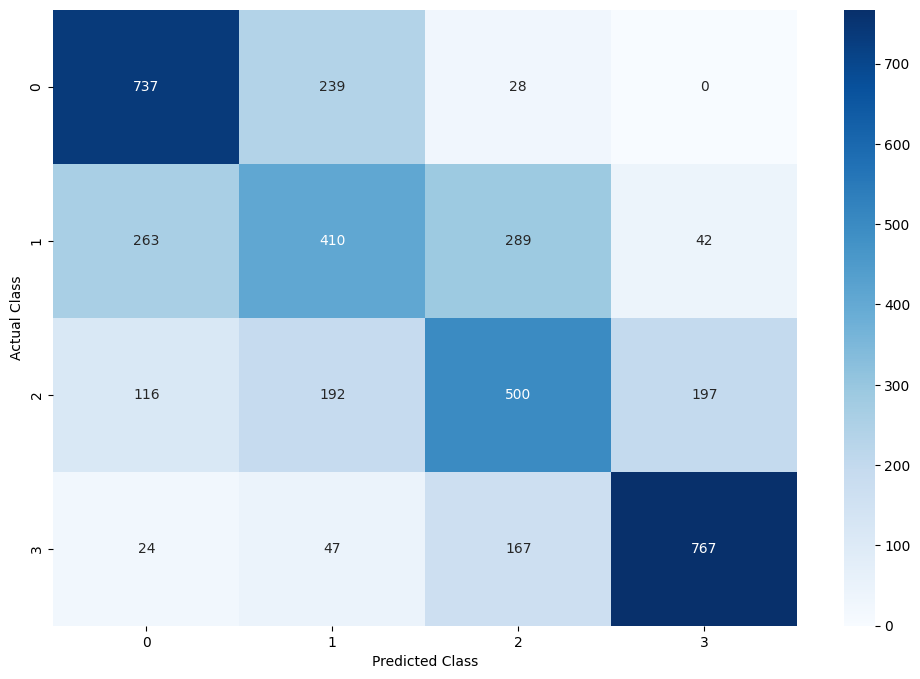

In [82]:
# 혼동행렬 시각화
plt.figure(figsize=(12, 8))

sns.heatmap(
    multi_cm,
    annot=True,
    fmt='d',
    cmap = 'Blues',
    xticklabels=[0, 1, 2, 3],
    yticklabels=[0, 1, 2 ,3]
    
)

plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

plt.show()

In [86]:
# ovr방식으로 다중 클래스를 분류
logR2 = LogisticRegression(multi_class='ovr', C = 10)
logR2.fit(X_train, Y_train)
pred2 = logR2.predict(X_test)
acc2 = accuracy_score(Y_test, pred2)
print(round(acc2, 2))

0.59
